# Intro to Centuri Hackathon 2023 Brainbow project

--- in progress ---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE
from PIL import Image

### Functions (TODO: move to library)

In [2]:
def load_data(ds, acts='spks'):
    
    # loading data
    fluo = np.load(f'data/{ds}/physiology/neural_activity/F.npy')
    spks = np.load(f'data/{ds}/physiology/neural_activity/spks.npy')
    iscell = np.load(f'data/{ds}/physiology/neural_activity/iscell.npy')

    if acts == 'spks':
        data = prepare_data(spks, iscell) # here choose spikes or fluorescence + get rid of non-cells + z-scores
    elif acts == 'fluo':
        data = prepare_data(fluo, iscell)
        
    t_max = data.shape[1]
    n_max = data.shape[0]
    
    print('Length of recording (timestamps): ', t_max)
    print('Number of ROIs: ', n_max)

    return data

In [3]:
def prepare_data(data_in, iscell):
    
    iscell_bool = iscell[:,0].astype(bool) # getting rid of 'non-cells'
    
    data = data_in[iscell_bool,:] # choose which data to analyse (spks or fluo)
    data = (data-np.mean(data,1)[:,np.newaxis])/np.std(data,1)[:,np.newaxis]
    
    return data

In [4]:
def get_tstamps(tseries, F):
    return np.arange(0, tseries.shape[1]/F, 1/F)

In [5]:
def load_tiff(ds, channel=''):
    img = Image.open(f'data/{ds}/anatomy/{channel}.tif')
    return np.array(img)

In [6]:
def fov_show(img, cmap='Greys_r', vmax_fact=1/2, title=''):
    plt.figure(dpi=100)
    plt.imshow(img,cmap=cmap, vmax = np.max(img)*vmax_fact)
    plt.axis('off')
    plt.title(title)
    plt.show()


In [7]:
            
def plot_acts(tstamps, data, bottom_plot='Mean', add_plot=None, tmin=0, tmax=None, title='', save_path=None):
    
    # shortening data (optional)
    ind_tmax = data.shape[1] if tmax==None else int(tmax/(tstamps[1]-tstamps[0]))
    ind_tmin = int(tmin/(tstamps[1]-tstamps[0]))
    
    data = data[:, ind_tmin:ind_tmax]
    tstamps = tstamps[ind_tmin:ind_tmax]
    
    # plotting
    _, axs = plt.subplots(2, 1, figsize=(10,4), dpi = 400, gridspec_kw={'height_ratios': [3, 1]})
    
    axs[0].imshow(data, cmap='binary', interpolation='nearest', aspect='auto', vmin=0, vmax=3.291) # z scored for 0.001
    axs[0].xaxis.set_visible(False)
    axs[0].set_ylabel('roi id')
    axs[0].set_title(title)
    
    plot_mean = (np.mean(data, axis=0)-np.min(np.mean(data, axis=0)))/np.max((np.mean(data, axis=0)-np.min(np.mean(data, axis=0))))
    
    if type(bottom_plot) == str:
        axs[1].plot(tstamps, plot_mean, label='avg')
    else:
        axs[1].plot(tstamps, bottom_plot[ind_tmin:ind_tmax], label='avg')
        
    if not add_plot is None:
        axs[1].plot(tstamps, add_plot[ind_tmin:ind_tmax], label='add_plot', alpha=0.5, c='grey')
    axs[1].set_xlim((np.min(tstamps)), np.max(tstamps))
    axs[1].set_ylabel('% active')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylim([-0.1, 1.1])

    if type(save_path) == str:
        save_filename = os.path.join(save_path, title)
        plt.savefig(save_filename)
            
def plot_acts_sorted(tstamps, data, embedding, bottom_plot='Mean', add_plot=None, component=0, tmin=0, tmax=None, title='embedding', save_path=None):
        
    # getting sorting indices
    temp = np.argsort(embedding[:,component])
    
    plot_acts(tstamps, data[temp,:], bottom_plot=bottom_plot, add_plot=add_plot, tmin=tmin, tmax=tmax, title=title, save_path=save_path)
    
    if type(save_path) == str:
        save_filename = os.path.join(save_path, title)
        plt.savefig(save_filename)


In [8]:
def plot_traces(tstamps, fluo, ind_neurons, tmin=0, tmax=None, title='', save_path=None):

    ind_tmax = fluo.shape[1] if tmax==None else int(tmax/(tstamps[1]-tstamps[0]))
    ind_tmin = int(tmin/(tstamps[1]-tstamps[0]))
    
    fluo_plot = fluo[ind_neurons, ind_tmin:ind_tmax]
    tstamps_plot = tstamps[ind_tmin:ind_tmax]
    
    fig, axs = plt.subplots(10, 1, figsize=(5,5), dpi=200)
    axs[0].set_title(title)
                   
    for i in range(len(ind_neurons)):
        
        axs[i].plot(tstamps_plot, fluo_plot[i,:], linewidth=0.5)

        axs[i].set_yticks([]) # y label is arbitrary units
        axs[i].set_ylabel("")
        axs[i].spines["top"].set_linewidth(0)
        axs[i].spines["right"].set_linewidth(0)
        axs[i].spines["left"].set_linewidth(0)  

        if i != len(ind_neurons)-1:
            axs[i].spines["bottom"].set_linewidth(0)
            axs[i].set_xticks([])
            axs[i].set_xlabel("")
        else:
            axs[i].set_xlabel('Time (s)')
        
        if type(save_path) == str:
            save_filename = os.path.join(save_path, title)
            plt.savefig(save_filename)


In [9]:
def fit_tsne_1d(data):
    print('fitting 1d-tSNE...')
    # default openTSNE params
    tsne = TSNE(
        n_components=1,
        perplexity=30,
        initialization="pca",
        metric="euclidean",
        n_jobs=8,
        random_state=3,
    )

    tsne_emb = tsne.fit(data.T)
    return tsne_emb

### Choosing dataset

In [10]:
ds = 'day3' # choose day3 for starters
F = 10 # all data here is acquired at 10 Hz

### Loading data

In [11]:
# loading images (anatomy)
img_r = load_tiff(ds, channel='red')
img_g = load_tiff(ds, channel='green')
img_b = load_tiff(ds, channel='blue')

In [12]:
# loading activity (physiology)
tseries = load_data(ds, acts='fluo')
tstamps = get_tstamps(tseries, F) # timestamps vector

Length of recording (timestamps):  12378
Number of ROIs:  361


### Basic plots

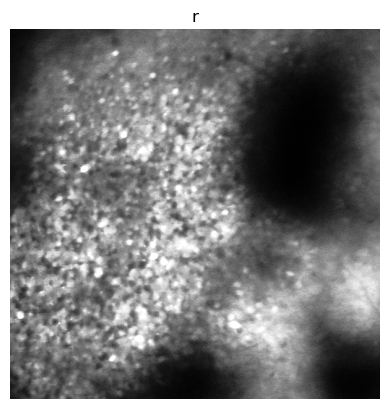

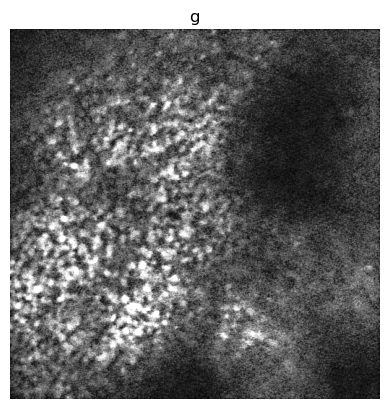

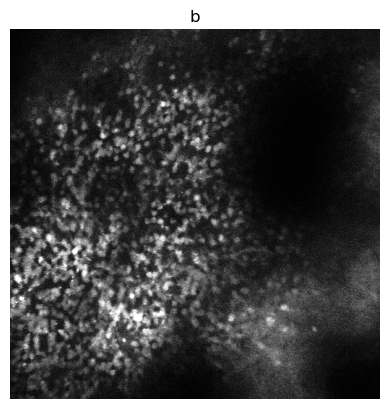

In [13]:
fov_show(img_r, title='r')
fov_show(img_g, title='g')
fov_show(img_b, title='b')

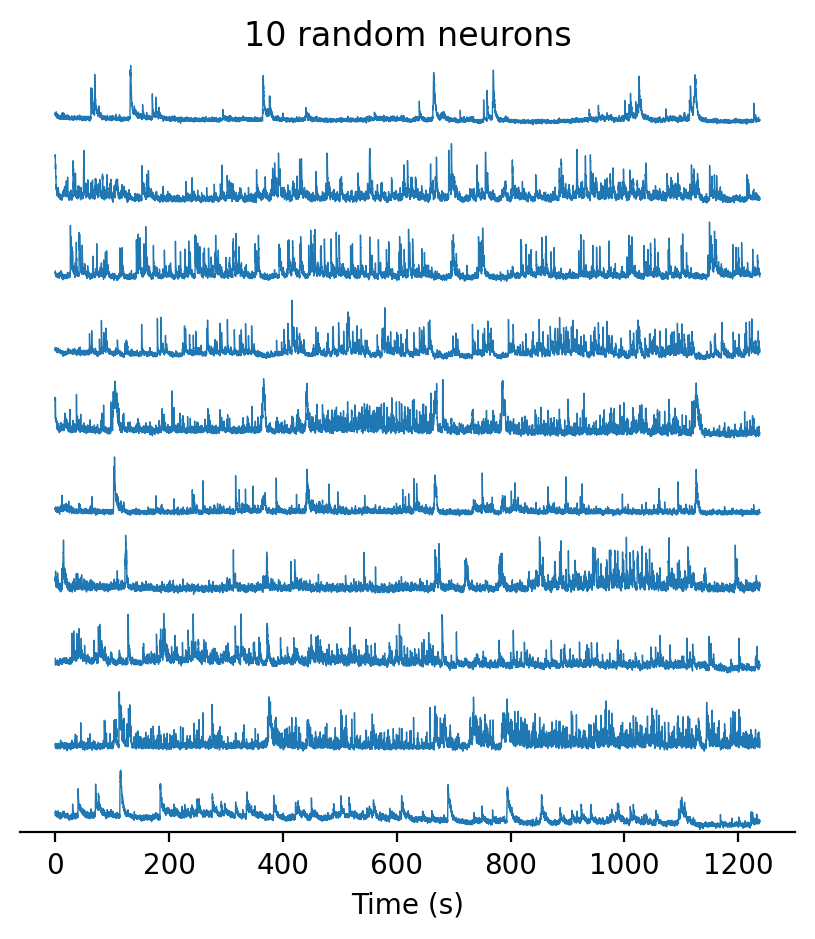

In [14]:
ind_neurons = np.arange(10) # top 10
plot_traces(tstamps, tseries, ind_neurons, title='10 random neurons')

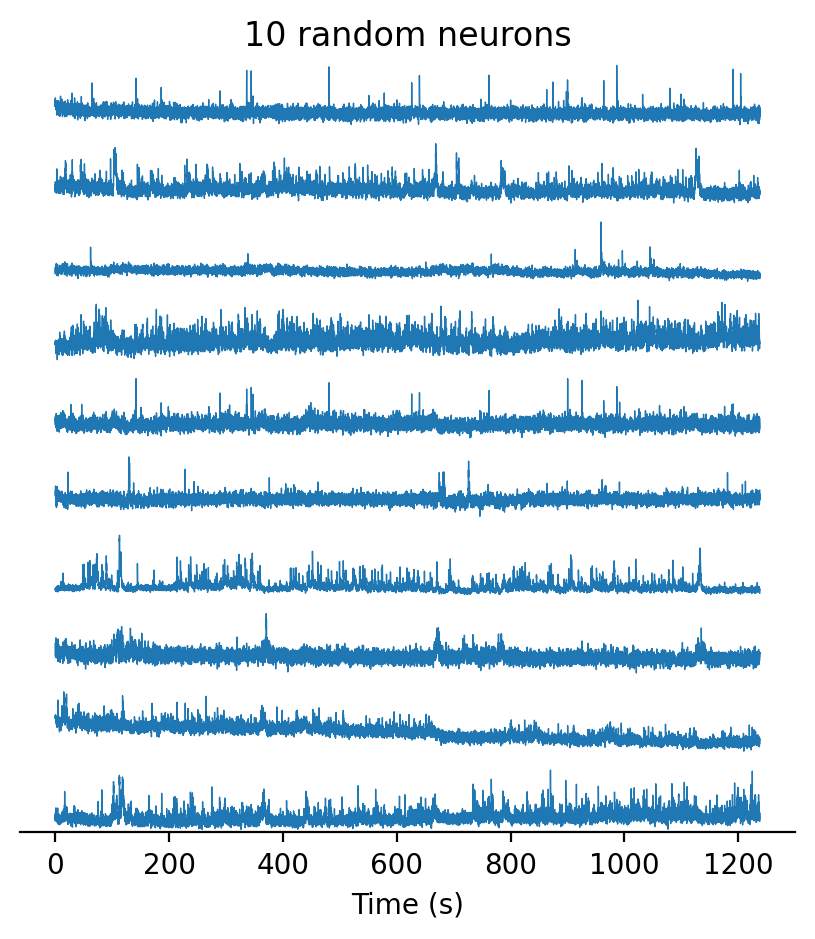

In [15]:
ind_neurons = np.random.randint(0, tseries.shape[0], 10) # 10 random indices
plot_traces(tstamps, tseries, ind_neurons, title='10 random neurons')

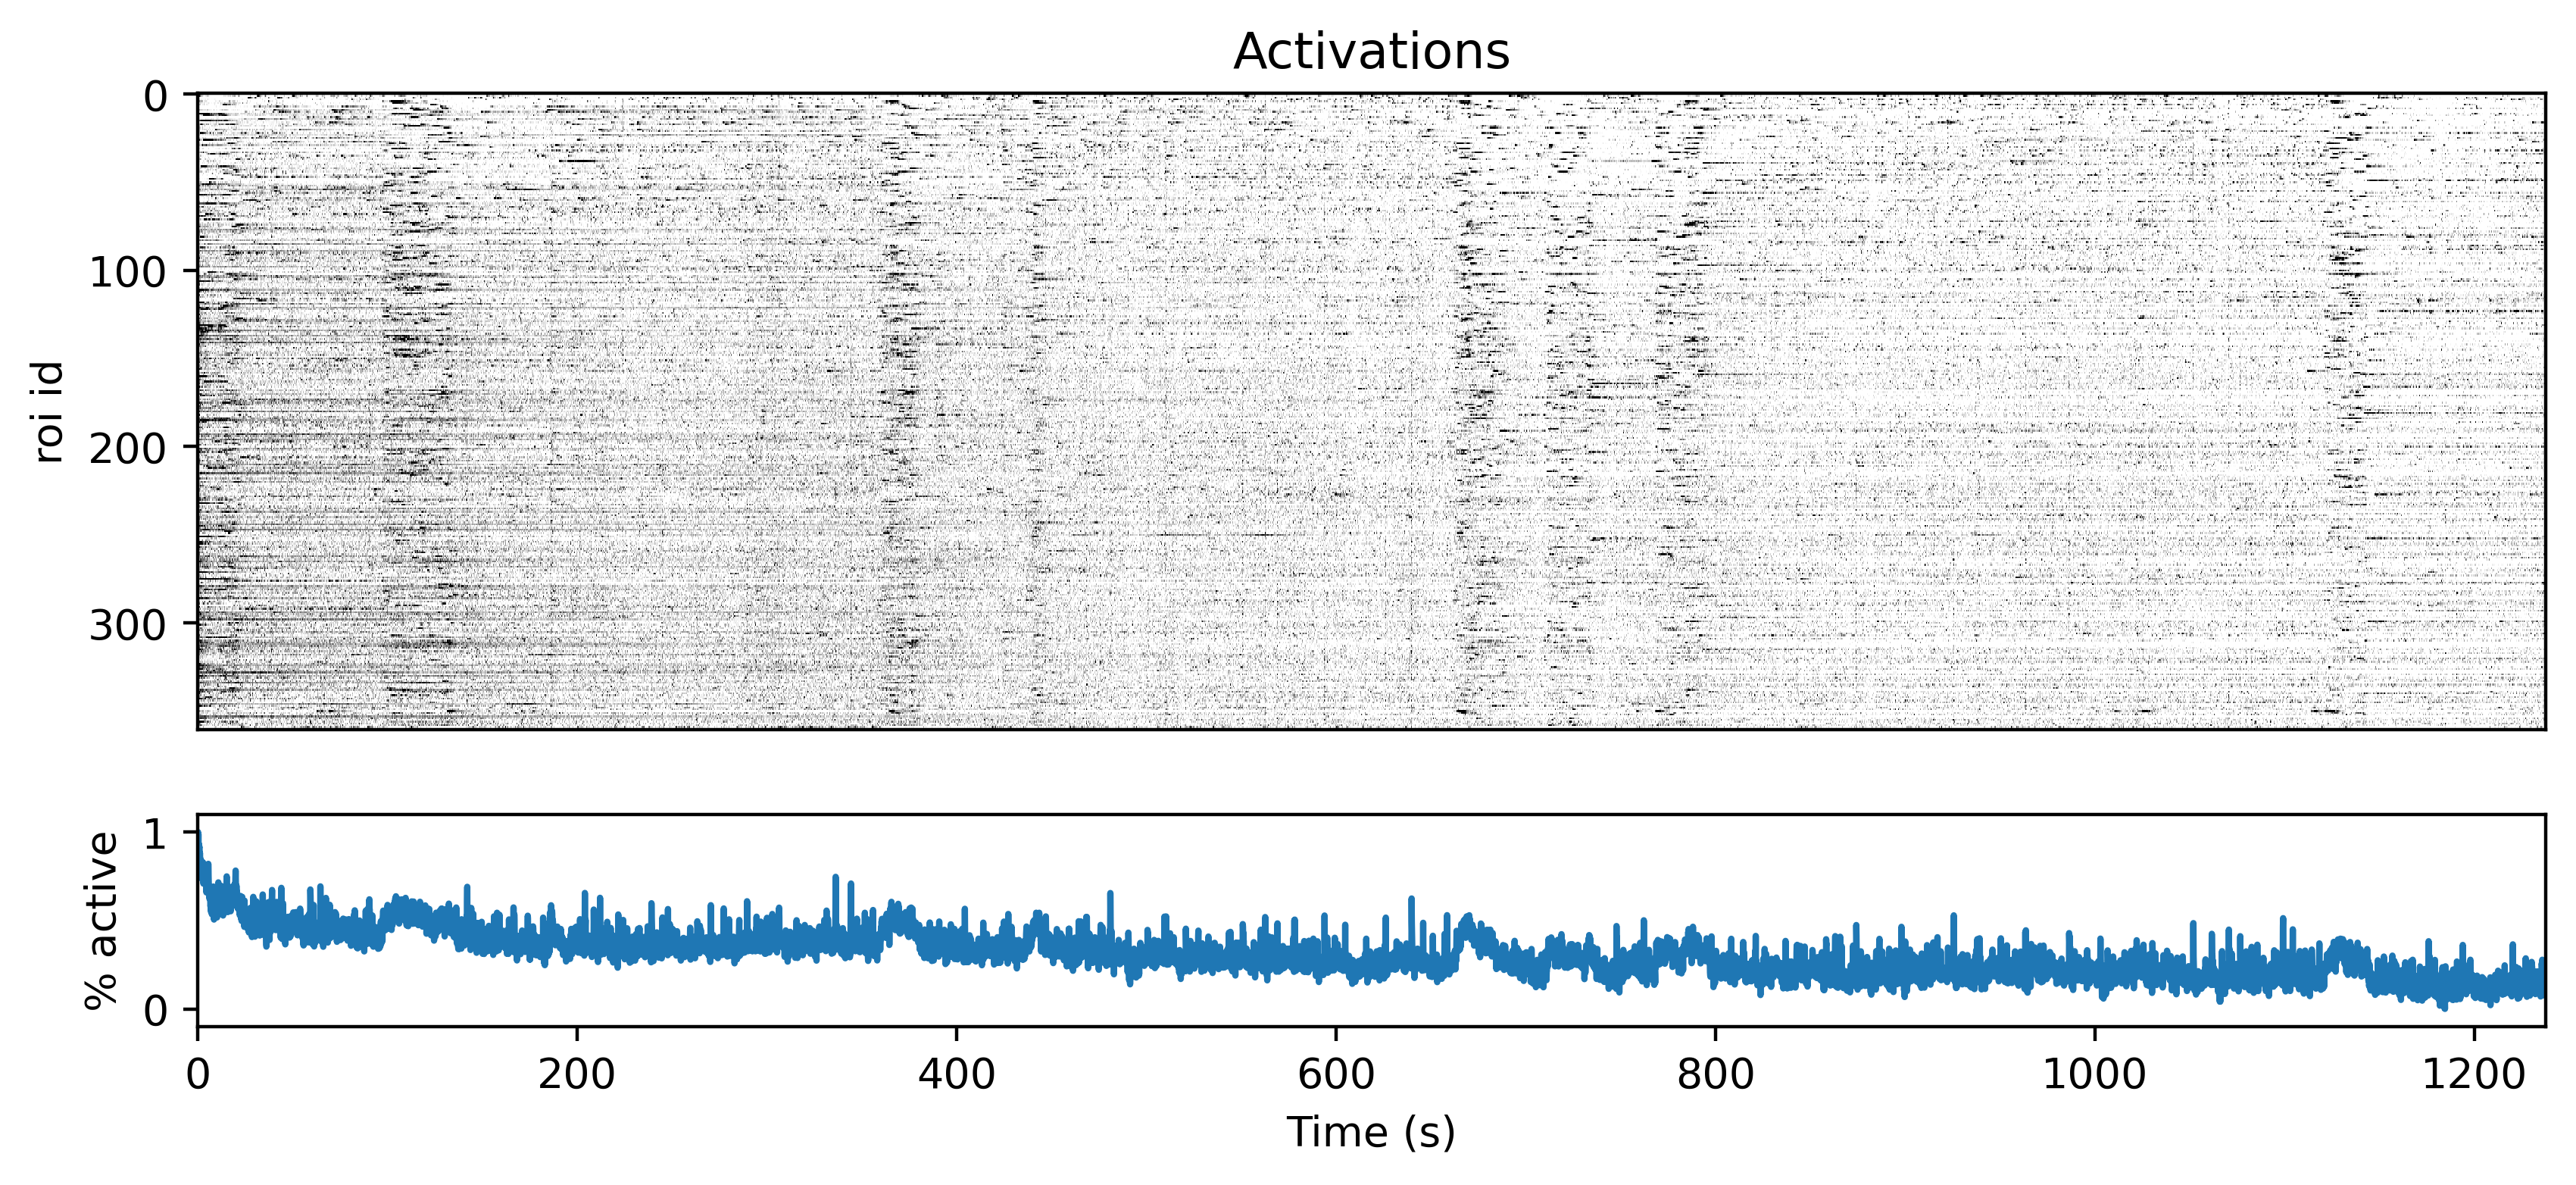

In [16]:
plot_acts(tstamps, tseries, title='Activations')

fitting 1d-tSNE...


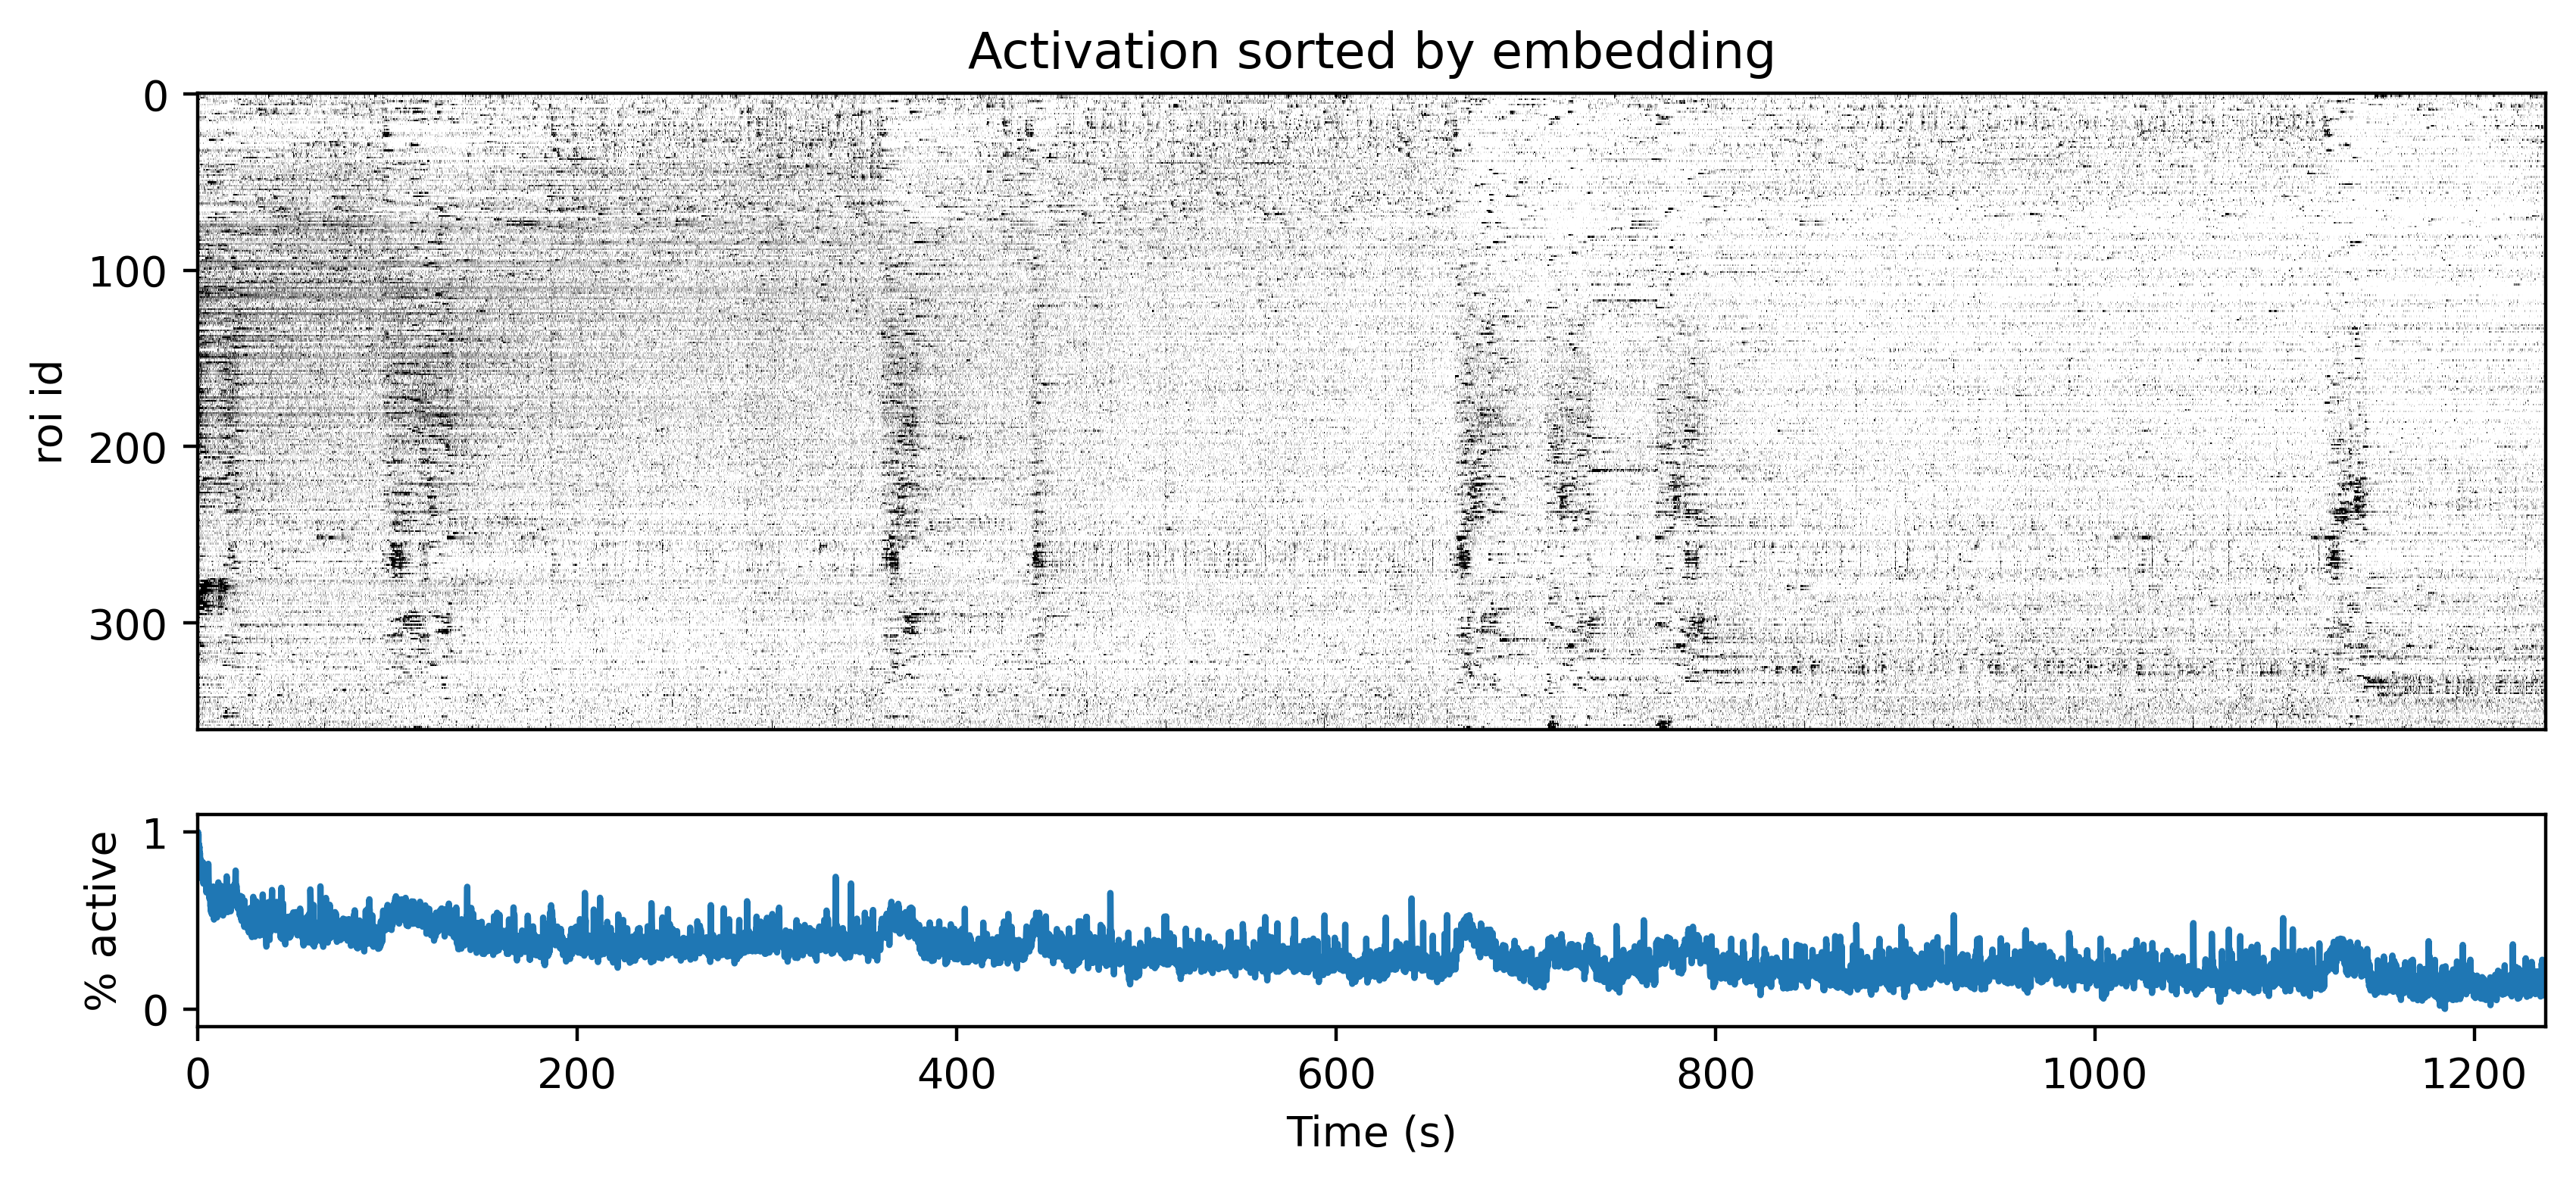

In [17]:
embedding = fit_tsne_1d(tseries.T) # this can take some time on a laptop
plot_acts_sorted(tstamps, tseries, embedding, title='Activation sorted by embedding')

TODO: loading suite2p ROIs and plotting overlayed as contours (this will be the last step before the hackathon)